### 데이터 로드


In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
from scipy.optimize import minimize, LinearConstraint, basinhopping #최적화 패키지

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
myfile = files.upload()
dividend = pd.read_csv('Dividend.csv') # 2000년 ~ 2022년, 30개 종목의 배당금 데이터

Saving Dividend.csv to Dividend.csv


In [ ]:
myfile = files.upload()
stock = pd.read_csv('StockPrice.csv') # 2000-01-03 ~ 2022-10-28, 30개 종목의 주가 데이터

Saving StockPrice.csv to StockPrice.csv


In [ ]:
myfile = files.upload()
exchange = pd.read_csv('ExchangeRate.csv') # 2000-01 ~ 2022-11, 한 달 평균 환율 데이터

Saving ExchangeRate.csv to ExchangeRate.csv


In [ ]:
myfile = files.upload()
param = pd.read_excel('Parameter.xlsx') # 1번 제약식의 계수, 2번 제약식의 계수, 목적함수의 계수, 고든 지수 등

Saving Parameter.xlsx to Parameter.xlsx


In [ ]:
# 데이터 전처리: 날짜 데이터 타입으로 변환
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

dividend['Ex-Dividend Date'] = pd.to_datetime(dividend['Ex-Dividend Date'])
dividend = dividend.sort_values('Ex-Dividend Date')
dividend['Month'] = dividend['Ex-Dividend Date'].apply(lambda x: x.month)

exchange['Date'] = pd.to_datetime(exchange['Date'])

In [ ]:
tickers = pd.read_excel('Parameter.xlsx', sheet_name='coeff').T.index[1:] #Ticker 데이터
print(tickers)

Index(['WBA', 'LEG', 'BEN', 'SWK', 'XOM', 'CVX', 'BKH', 'NFG', 'CAT', 'TGT',
       'ITW', 'EMR', 'APD', 'PG', 'JNJ', 'ATO', 'GPC', 'GD', 'AOS', 'HRL',
       'LOW', 'PPG', 'PH', 'ABM', 'ADM', 'ABT', 'CWT', 'ADP', 'TNC', 'DOV'],
      dtype='object')


### 백테스팅 -슬라이딩 윈도우 적용

In [ ]:
##### 최적화 함수 #####

def WeightMeasure(year, investment):
    
    ### 슬라이딩 윈도우 ###
    year1String = str(year-5)
    year2String = str(year-2)
    year3String = str(year-1)
    
    str1 = year1String + '-01-01'
    str2 = year2String + '-12-31'
    str3 = year3String + '-01-01'
    str4 = year3String + '-12-31'

    if year == 2022:
      str4 = '2022-10-28' # 2022년은 10-28일까지만 주가 데이터가 있음

    stock_fore = stock.set_index('Date')[str1:str2] # 5년 전 ~ 2년 전 주가
    stock_back = stock.set_index('Date')[str3:str4] # 1년 전 주가

    cov = (0.8 * stock_fore.pct_change().cov()) + (0.2 * stock_back.pct_change().cov()) # 공분산 => 5년전~2년전 : 1년전 = 8 : 2 비중 적용
    cov = cov * 252 # 연간 공분산 => 미국 1년 평균 개장일 252일 곱하기

    obj_temp = pd.read_excel('Parameter.xlsx', sheet_name='coeff')
    obj_params = np.array(obj_temp[obj_temp['연도'] == year].iloc[0, 1:]) # 목적함수 계수
    cons_temp = pd.read_excel('Parameter.xlsx', sheet_name='cons')
    cons1 = cons_temp[cons_temp['연도'] == year].iloc[:, 2:] # 1번 제약식 계수
    cons2 = pd.concat([cons1, cons1]) # 2번 제약식 계수

    if pd.to_datetime(str4) not in np.array(stock['Date']): # 12/31이 영업일이 아닐 때에는 주가 데이터가 없어서 12/30의 데이터를 확인
        str4 = year3String + '-12-30'
    if pd.to_datetime(str4) not in np.array(stock['Date']):
        str4 = year3String + '-12-29'

    price = np.array(stock[stock['Date'] == str4].iloc[0, 1:])

    theta_array = []
    profit_array = []
    weight_array = []

    ### 최적 세타 값 탐색 ###
    for theta in range(1, 14): # 세타가 12가 넘어가면 어느 함수에서든 영향력이 작았기에 1~13 사이에서 세타 탐색
    
        ### 목적함수
        def obj(x):
            revenue = 0
            x = np.array(x) # 변수 정의
            total_investment = np.dot(x, price) # 전체 투자 금액
            weights = (x * price) / total_investment # 투자 비중
            variance = np.dot(weights.T, np.dot(cov, weights))
            variance = np.sqrt(variance) # 변동성
            for i in range(0, 12):
                div_i = np.dot((x * -obj_params), (cons1.iloc[i, :].values))
                revenue +=  div_i
            result = (revenue / total_investment) + (theta * variance) # 목적함수
            return result

        ### 제약식
        cons = [{'type': 'eq', 'fun': lambda x: np.dot(x, price) - investment}] # 전체 투자금액 제약
        for i in range(0, 12): # 매달 배당 받아야 함
            cons.append(LinearConstraint(np.array(cons1.iloc[i, :]), lb=0, ub=np.inf))
        for i in range(0, 12): # 매달 배당 하한선 $600 제약
            cons.append({'type': 'ineq', 'fun': lambda x: np.dot(x, cons2.iloc[i, :]) - 600})

        bnds = ((0, None), ) * 30 # 결정변수 값이 모두 0이상
        x0 = np.array([1] * 30) # 초기값

        ### Global Minimum 찾기
        minimizer_kwargs = {"method":"SLSQP", "constraints":cons, "bounds":bnds}
        res = basinhopping(obj, x0, minimizer_kwargs=minimizer_kwargs, niter=10)

        weight = (res.x * price) / np.dot(res.x, price) # 최적 투자비중
        pair = [pair for pair in zip(tickers, [format(x, '.2f') for x in res.x], ['{:.2f}%'.format(x * 100) for x in weight])]

        total = 0
        for i in range(0, 12):
            div_i = np.dot((res.x * obj_params), (cons1.iloc[i, :].values))
            total +=  div_i
        theta_array.append(theta) # 세타 값
        profit_array.append(total) # 예상 배당금
        weight_array.append(weight) # 투자 비중

    ### 최적 세타 값에 따른 최적화 결과 ###
    opt_index = np.argmax(profit_array) # 예상 배당금을 최대화하는 최적 세타 값
    print('최적의 세타 값은 {} 입니다.'.format(theta_array[opt_index]))
    weight = weight_array[opt_index] # 최적 투자비중
    variance = np.dot(weight.T, np.dot(cov, weight))
    variance = np.sqrt(variance)
    print(str1 +' ~ '+ str4)
    return weight, variance

In [ ]:
##### 리밸런싱 함수 #####

def Rebalancing(year, weight, investment):
    price_start = np.array(stock[stock['Date'].apply(lambda x: x.year) == year].iloc[0, 1:]) # 1월 1일 주가
    price_end = np.array(stock[stock['Date'].apply(lambda x: x.year) == year].iloc[-1, 1:]) # 12월 31일 주가
    allocation = (weight * investment) / price_start # 종목별 주식 수
    
    div = []
    for ticker in tickers:
        temp = dividend[dividend['Ex-Dividend Date'].apply(lambda x: x.year) == year]
        div.append(np.sum(temp[temp['Ticker'] == ticker]['Dividend']))
    
    m = []
    for i in range(1, 13):
        temp = dividend[dividend['Ex-Dividend Date'].apply(lambda x: x.year) == year].groupby(['Month', 'Ticker']).sum()['Dividend'].to_frame().reset_index()
        temp = temp[temp['Month'] == i].drop('Month', axis=1).set_index('Ticker').T
        a = []
        for ticker in tickers:
            try: a.append(np.float(temp[ticker]))
            except: a.append(0)
        monthly = np.dot(allocation, a) # 월별 배당금
        m.append(monthly)

    actual_stock = np.dot(allocation, price_end) # 연말 포트폴리오 가치
    actual_dividend = np.dot(allocation, div) # 배당금 총합
    
    return actual_stock, actual_dividend, m

In [ ]:
investment = 300000 # 초기 투자 금액: 30만 달러
tax_cum_d = 0
tax_cum_w = 0
div_cum_d = 0
div_cum_w = 0

weight_temp = []
variance_temp = []
years = [y for y in range(2015, 2023)] # 백테스팅 연도 설정

for year in years:
    weight, variance = WeightMeasure(year, investment) # 최적화
    weight_temp.append(weight)
    variance_temp.append(variance)
    actual_stock, actual_dividend, m = Rebalancing(year=year, weight=weight, investment=investment) # 1년 주기 리밸런싱
    x0 = investment
    investment = actual_stock
    x1 = actual_stock
    rate = exchange[exchange['Date'].apply(lambda x: x.year) == year]
    profit = x1 - x0 # 수익: 연말 포트폴리오 가치 - 연초 투자 금액

    ### 세금 계산
    if profit * rate.iloc[0, 1] > 2500000:
      tax = ((profit * rate.iloc[0, 1]) - 2500000) * 0.22 # 0.22: 해외주식 수익의 250만원을 제외한 금액에 대해 양도소득세 22% 적용
      x1 = x1 - (tax/rate.iloc[0, 1])
    else:
      tax = 0

    tax_cum_w += tax
    tax_cum_d += tax/rate.iloc[0, 1]

    print('{0}년 세전 포트폴리오 가치: ${1:.2f} / 세금: ${2:.2f} / ￦{4:.0f}\n{0}년 세후 포트폴리오 가치: ${3:.2f}'.format(year, investment, tax/rate.iloc[0, 1], x1, round(tax,-2)))
    print('{}년 세전 배당금: ${:.2f} / 세후 배당금: ${:.2f} / 배당수익률 {:.2f}% '.format(year, actual_dividend, actual_dividend*0.85,actual_dividend/x0*100))
    print('누적 세금 ${:0.2f} / ￦{:.0f}'.format(tax_cum_d,tax_cum_w))
    print('')
    investment = x1 # 세후 포트폴리오 가치로 재투자
        
    for i in range(0, 12):
        if year == 2022 and (i == 12 or i ==11): # 데이터 없는 2022년 11월, 12월은 패스
          continue
        else:
          print('{}월 세전 배당금: ${:.2f} / 세후 배당금: ${:.2f} / 원화 배당금 ￦{:.0f}'.format(i+1, m[i], m[i]*0.85,round(m[i]*0.85*rate.iloc[i, 1],-3))) # 0.85: 미국 주식 배당소득세 15% 제외한 후 지급받는 배당금
          div_cum_d += m[i]*0.85
          div_cum_w += m[i]*0.85*rate.iloc[i, 1]
    print('누적 실질 수령 배당금 ${:.2f} ￦{:.0f}'.format(div_cum_d,div_cum_w))
    print('\n---------------------------------------------------------')

최적의 세타 값은 7 입니다.
2010-01-01 ~ 2014-12-31
2015년 세전 포트폴리오 가치: $280546.04 / 세금: $0.00 / ￦0
2015년 세후 포트폴리오 가치: $280546.04
2015년 세전 배당금: $8037.99 / 세후 배당금: $6832.29 / 배당수익률 2.68% 
누적 세금 $0.00 / ￦0

1월 세전 배당금: $421.06 / 세후 배당금: $357.90 / 원화 배당금 ￦421000
2월 세전 배당금: $959.73 / 세후 배당금: $815.77 / 원화 배당금 ￦946000
3월 세전 배당금: $579.72 / 세후 배당금: $492.76 / 원화 배당금 ￦562000
4월 세전 배당금: $430.99 / 세후 배당금: $366.34 / 원화 배당금 ￦434000
5월 세전 배당금: $991.66 / 세후 배당금: $842.91 / 원화 배당금 ￦996000
6월 세전 배당금: $580.48 / 세후 배당금: $493.41 / 원화 배당금 ￦575000
7월 세전 배당금: $434.11 / 세후 배당금: $368.99 / 원화 배당금 ￦413000
8월 세전 배당금: $1008.27 / 세후 배당금: $857.03 / 원화 배당금 ￦953000
9월 세전 배당금: $585.64 / 세후 배당금: $497.79 / 원화 배당금 ￦536000
10월 세전 배당금: $434.11 / 세후 배당금: $368.99 / 원화 배당금 ￦409000
11월 세전 배당금: $1013.51 / 세후 배당금: $861.48 / 원화 배당금 ￦948000
12월 세전 배당금: $598.71 / 세후 배당금: $508.91 / 원화 배당금 ￦561000
누적 실질 수령 배당금 $6832.29 ￦7752722

---------------------------------------------------------
최적의 세타 값은 12 입니다.
2011-01-01 ~ 2015-12-31
2016년 세전 포트폴리오 가치: $31

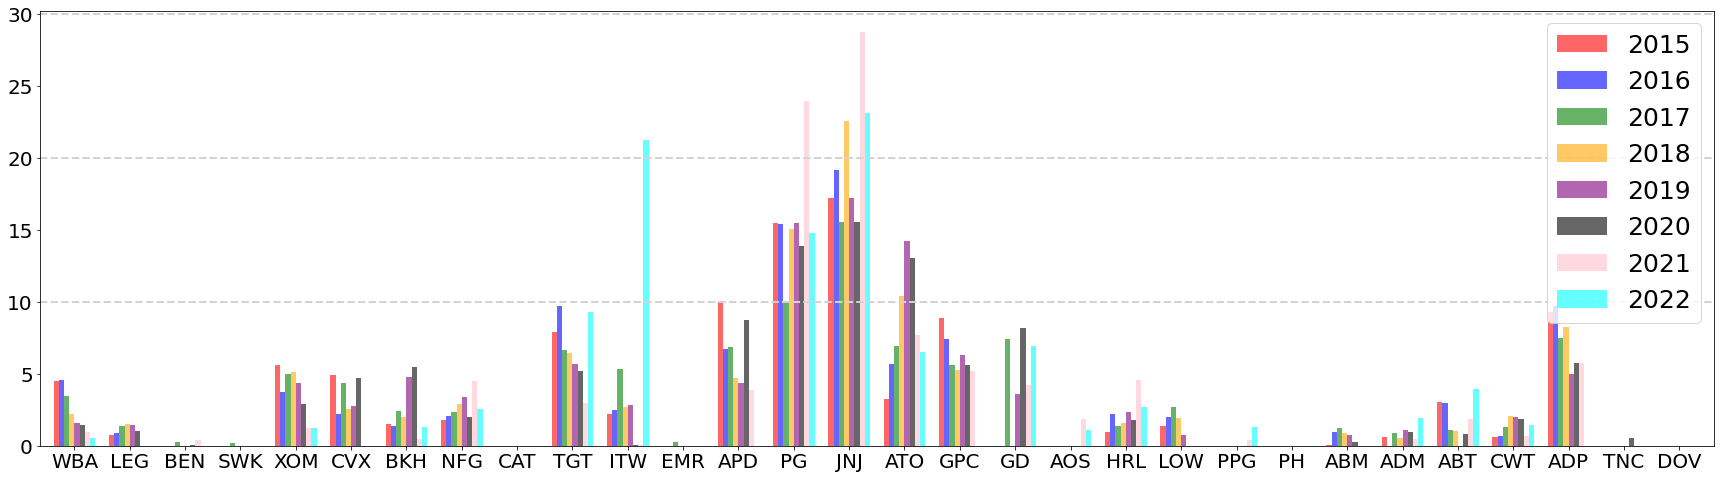

In [ ]:
### 연도별 최적 투자 비중 그래프 ###
import matplotlib.pyplot as plt

weight_temp_ = []
for i in range(len(weight_temp)):
    weight_temp_.append(weight_temp[i] * 100)
    
graph = pd.DataFrame(weight_temp_, columns=tickers, index=years).T.reset_index()

graph.plot(x="index", y=years, kind="bar",color=['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan'], alpha = 0.6, width = 0.75, figsize=(30,8))
plt.axhline(10, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.axhline(20, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.axhline(30, 0, 30, color='lightgray', linestyle='--', linewidth=2)
plt.xticks(np.arange(len(tickers)), tickers, rotation=0, fontsize=20)
plt.yticks(np.arange(0, 35, 5), fontsize=20)
plt.legend(fontsize=25, loc='upper right')
plt.xlabel(None)
plt.show()

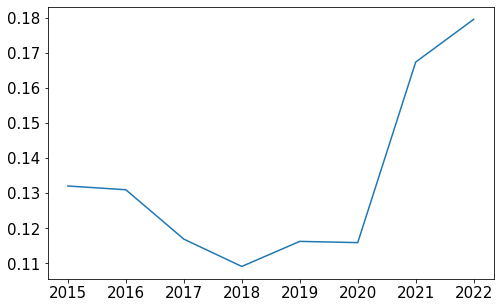

In [ ]:
### 연도별 변동성 그래프 ###
plt.figure(figsize=(8,5))
plt.plot(years, variance_temp)
plt.xticks(years, years, fontsize=15)
plt.yticks(fontsize=15)
plt.show()